In [1]:
import matplotlib.pyplot as plt

from fitting_uncertainty import create_ensemble, load_data, create_datasets
import torch


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
save_dir = "uncertainty/ensemble_mse_scale_1.0"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load("uncertainty/train.dset")
test_dset = torch.load("uncertainty/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2

ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 100000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble.cuda();

ensemble.cuda();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from phase_space_reconstruction.utils import calculate_ellipse
# calculate rms stats from each image
covs = []
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]

covs = torch.stack(covs)

# plot reconstruction covs
with torch.no_grad():
    predictions = []
    for i in range(len(ensemble)):
        p, _, _ = ensemble[i](quad_strengths[:,0,:].cuda())
        predictions += [p]

predictions = torch.stack(predictions).cpu().transpose(0,1)
rcovs = []
for ele in predictions.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    rcovs += [cov]

rcovs = torch.stack(rcovs)
rcovs_mean = rcovs.mean(dim=1)
rcovs_std = rcovs.std(dim=1)

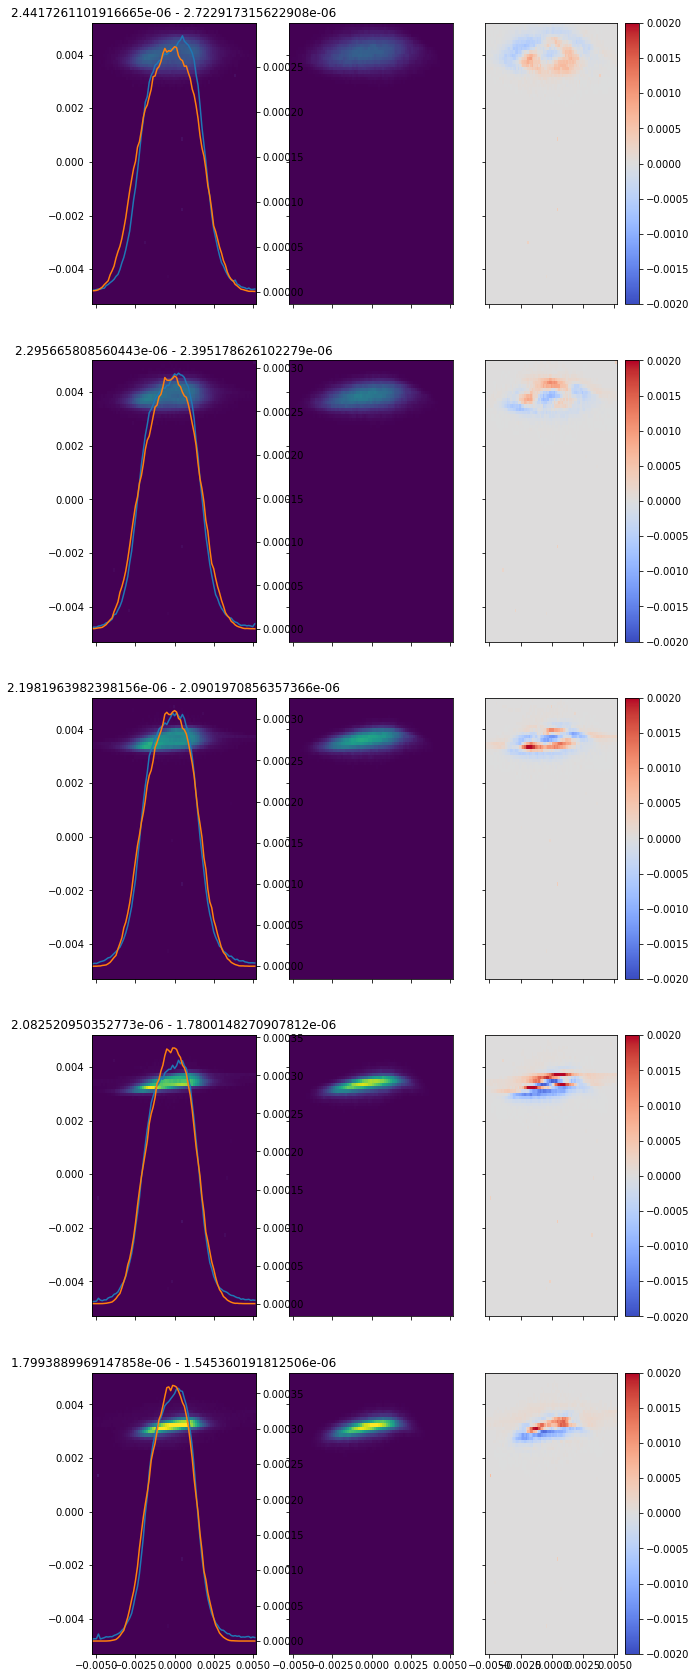

In [3]:
fig,ax = plt.subplots(len(predictions[:5]),3,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(predictions[:5])):
    ax[i][0].pcolor(*xx, image_data[i][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

    c = ax[i][2].pcolor(*xx,image_data[i][0].cpu().detach() - predictions[i][0].cpu()
                    .detach(),cmap="coolwarm",vmin=-2e-3, vmax=2e-3)
    fig.colorbar(c, ax=ax[i][2])
    axb = ax[i][0].twinx()
    axb.plot(bins, image_data[i][0].sum(dim=-2)*0.01)
    axb.plot(bins, predictions[i][0].sum(dim=-2)*0.01)
    axb.set_title(f"{covs[i,0,1,1]} - {rcovs[i,0,1,1]}")


<ErrorbarContainer object of 3 artists>

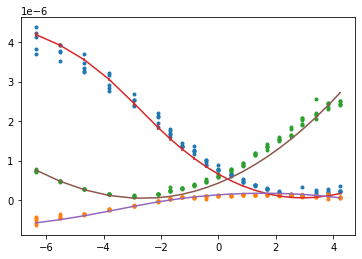

In [4]:
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,0,0].detach().cpu().flatten(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,0].detach().cpu().flatten(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,1].detach().cpu().flatten(),".")

plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,0,0]
             .flatten(), rcovs_std[...,0,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,0]
             .flatten(), rcovs_std[...,1,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,1]
             .flatten(), yerr=rcovs_std[...,1,1].flatten())
#plt.plot(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs[...,1,0].flatten(),"+")
#plt.plot(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs[...,1,1].flatten(),"+")


tensor(3317.3440, grad_fn=<MseLossBackward0>)
tensor(0.5757, grad_fn=<MseLossBackward0>)
tensor(0.2226, grad_fn=<MseLossBackward0>)
tensor(0.0923, grad_fn=<MseLossBackward0>)
tensor(0.0579, grad_fn=<MseLossBackward0>)
tensor(0.0470, grad_fn=<MseLossBackward0>)
tensor(0.0430, grad_fn=<MseLossBackward0>)
tensor(0.0414, grad_fn=<MseLossBackward0>)
tensor(0.0407, grad_fn=<MseLossBackward0>)
tensor(0.0404, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.0401, grad_fn=<MseLossBackward0>)
[('lambda_1', Parameter containing:
tensor(0.2176, requires_grad=True)), ('lambda_2', Parameter containing:
tensor(0.2030, requires_grad=True)), ('c', Parameter containing:
tensor(-4.1046, requires_grad=True))]
tensor(7.8658e-07, grad_fn=<DivBackward0>)
tensor(3328.1948, grad_fn=<MseLossBackward0>)
tensor(0.1108, grad_fn=<MseLossBackward0>)
tensor(0.0413, grad_fn=<MseLossBackward0>)
tensor(0.0097, grad_fn=<MseLossBackward0>)
tensor(0.

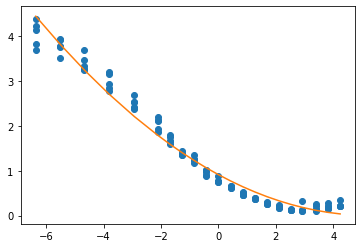

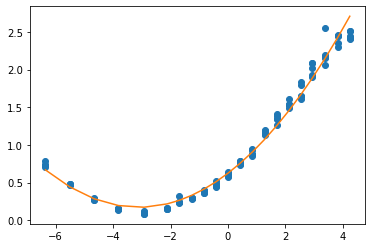

In [5]:
from phase_space_reconstruction.modeling import NormalizedQuadScan
from torch.nn.functional import mse_loss


# fit phase spaces
train_s11 = covs[...,0,0].detach().cpu().flatten()
train_s22 = covs[...,1,1].detach().cpu().flatten()

for ele in [train_s11, train_s22]:
    train_k = quad_strengths.flatten().cpu()
    quad_length = torch.tensor(0.12)
    drift = torch.tensor(3.38 - 0.12/2)
    A = train_s11.max().sqrt()

    model = NormalizedQuadScan(A, drift, quad_length)

    optimizer = torch.optim.Adam(
            model.parameters(), lr=0.01
    )

    if 1:
        for i in range(25000):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_k)
            # Calc loss and backprop gradients
            loss = mse_loss(output*1e6, ele*1e6)
            loss.backward()
            if not i % 2000:
                print(loss)
            optimizer.step()

        print(list(model.named_parameters()))

    with torch.no_grad():
        pred_y = model(train_k)
        plt.figure()
        plt.plot(train_k, ele*1e6, "o")
        plt.plot(train_k, pred_y.detach()*1e6)
    print(model.emittance() * 63.0 / 0.511)


In [11]:
# do bayesian linear regression using pyro
import pyro
from pyro import poutine

from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoNormal

class PyroNormalizedQuadScan(NormalizedQuadScan, PyroModule):
    def forward(self, k, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.05))
        mean = super().forward(k)*1e6
        with pyro.plate("data", k.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean



model = PyroNormalizedQuadScan(A, drift, quad_length)
model.lambda_1 = PyroSample(dist.Normal(1.0,5.0))
model.lambda_2 = PyroSample(dist.Normal(1.0,5.0))
model.c = PyroSample(dist.Normal(0.0,5.0))

posterior_module = pyro.nn.PyroModule("model")
posterior_module.guide = AutoNormal(poutine.block(model, hide=['bm']))


print(dict(model.named_parameters()))

{}


[iter 0]  loss: 55240.3714
[iter 50]  loss: 70819.8112
[iter 100]  loss: 26497.1403
[iter 150]  loss: 81763.6313
[iter 200]  loss: 20248.6822
[iter 250]  loss: 3217.9220
[iter 300]  loss: 6076.6609
[iter 350]  loss: 1643.0386
[iter 400]  loss: 806.8746
[iter 450]  loss: 5356.0755
[iter 500]  loss: 835.0340
[iter 550]  loss: 555.7460
[iter 600]  loss: 928.8973
[iter 650]  loss: 526.5505
[iter 700]  loss: 2862.0586
[iter 750]  loss: 1036.0184
[iter 800]  loss: 12072.0886
[iter 850]  loss: 640.1450
[iter 900]  loss: 553.5676
[iter 950]  loss: 615.2932
[iter 1000]  loss: 4140.0747
[iter 1050]  loss: 218.6125
[iter 1100]  loss: 507.3838
[iter 1150]  loss: 1246.1804
[iter 1200]  loss: 6432.0043
[iter 1250]  loss: 3.5077
[iter 1300]  loss: 1091.0942
[iter 1350]  loss: 422.7512
[iter 1400]  loss: 268.2627
[iter 1450]  loss: 91.7760
[iter 1500]  loss: 261.2434
[iter 1550]  loss: 0.3319
[iter 1600]  loss: 64.6998
[iter 1650]  loss: 300.7262
[iter 1700]  loss: 65.4266
[iter 1750]  loss: 8.2114
[i

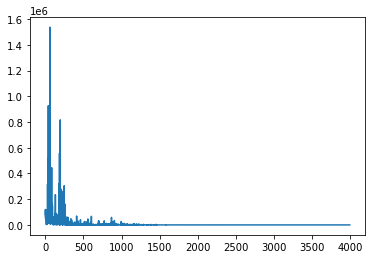

In [12]:
from pyro.infer import SVI, Trace_ELBO

def train(model, guide, *args, lr=0.001, n_steps=201, verbose=False):
    pyro.clear_param_store()
    initial_lr = lr
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
    svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

    losses = []
    for step in range(n_steps):
        loss = svi.step(*args)
        losses.append(loss)
        if step % 50 == 0 and verbose:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

    return losses

losses= train(
    model,posterior_module.guide, train_k, train_s22*1e6,
    lr=0.01,n_steps=4000, verbose=True
)
plt.plot(losses)

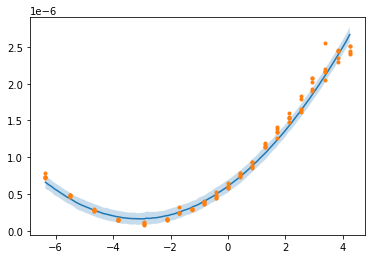

In [13]:
posterior_predictive = Predictive(model, num_samples=800, parallel=True,
                               guide=posterior_module.guide)
test_k = torch.linspace(train_k.min(),train_k.max(),100)

posterior_samples = posterior_predictive(test_k)

def get_stats(samples):
    mean = torch.mean(samples, dim=0)
    l = torch.quantile(samples, 0.05, dim=0)
    u = torch.quantile(samples, 0.95, dim=0)
    return mean, l, u

fig, ax = plt.subplots()
m, l, u = get_stats(posterior_samples["obs"].squeeze()/1e6)
ax.plot(test_k.squeeze().cpu(), m.cpu())
ax.fill_between(test_k.squeeze().cpu(), l.cpu(), u.cpu(), alpha=0.25)

ax.plot(train_k.squeeze().cpu(), train_s22.squeeze().cpu(), '.')

tensor([0.0000e+00, 4.0628e-08, 1.8237e-06, 2.7576e-05, 8.4283e-05])


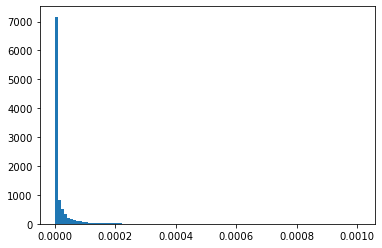

In [15]:
emittances = []
for i in range(10000):
    emittances+=[model.emittance()]
emittances = torch.tensor(emittances)
qs = torch.quantile(emittances, torch.tensor([0.05,0.5-0.34,0.5,0.5+0.34,0.95]))
print(qs)
plt.hist(emittances,bins=100);